In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from skimage.measure import find_contours

from SESMesh import SESMesh

import psi4

from rdkit import Chem
from rdkit.Chem import AllChem

from readcube import parse_cube

import open3d as o3d

#autocomplete wasn't working (or too slow) - this fixes it:
#%config Completer.use_jedi = False


# Load molecule and create a mesh

In [277]:
smi = 'C(C(=O)O)N' #glycine
smi = 'Oc1ccccc1' #phenol 
#smi = 'C1=CC=C2C(=C1)C=CN2' #indole
#smi = 'C1=CN=C2C(=C1)C=CN2' #7-azaindole
mol = Chem.MolFromSmiles(smi)

#optimize:
opt=True
if opt:
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
    AllChem.UFFOptimizeMolecule(mol)
    
    
def mol2xyz(mol, multiplicity=1):
    charge = Chem.GetFormalCharge(mol)
    xyz_string = "\n{} {}\n".format(charge, multiplicity)
    for atom in mol.GetAtoms():
        pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        xyz_string += "{} {} {} {}\n".format(atom.GetSymbol(), pos.x, pos.y, pos.z)
    return xyz_string

geom = psi4.geometry(mol2xyz(mol))

    
#mol = Chem.RemoveHs(mol)

In [278]:
f = open('mol.pdb','w')
f.write(Chem.MolToPDBBlock(mol))
f.close()

In [279]:
positions = mol.GetConformer(0).GetPositions()
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.GetAtoms()])

#init object
sesmol = SESMesh(1.4)

0
1
2


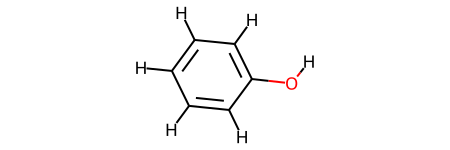

In [280]:
#generate a 2d template:
sesmol.golden_spiral(200)
#plt.scatter(*sesmol.template_points.T)

#generate surface and extended points for two atoms (defined above)
sesmol.generate_points(positions, radii)


sesmol.remove_bad_surface_points()
sesmol.remove_bad_extended_points()
sesmol.translate_reentrant_surfaces()
sesmol.sample_sdf()
sesmol.gen_grid(gridsize=0.2)
sesmol.interp()

mol


In [281]:
from skimage.measure import marching_cubes
vert, faces, norm, values= marching_cubes(sesmol.sdf, 
                                                  0, 
                                                  spacing=(sesmol.gridsize, 
                                                           sesmol.gridsize,
                                                          sesmol.gridsize))

import meshplot as mp
p = mp.plot(vert*sesmol.gridsize+sesmol.min_coords, faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-5.726492…

In [282]:
gridsize=0.3
buf=1.4

min_coords = sesmol.sampled_coords.min(0)
max_coords = sesmol.sampled_coords.max(0)

print(min_coords, max_coords)

#shift min and max to the nearest grid point outside the buffer zone:
max_coords = max_coords + (gridsize - (max_coords)%gridsize)
min_coords = min_coords - (gridsize + (min_coords)%gridsize)
print(min_coords, max_coords)

[-5.32138681 -4.78947574 -3.46149418] [5.69625792 4.70628774 3.52692001]
[-5.7 -5.1 -3.9] [5.7 4.8 3.6]


In [283]:
bins = list()

In [284]:
#for each dimension x,y,z:
for dim in range(min_coords.shape[0]):
    print(dim)
    grid = np.linspace( min_coords[dim],
                       max_coords[dim],
                       int((max_coords[dim]-min_coords[dim])/gridsize+1)
                      )
    bins.append(grid)

0
1
2


In [285]:
[b.shape for b in bins]

[(39,), (34,), (26,)]

In [286]:
mgrid = np.meshgrid(bins[0], bins[1], bins[2],indexing='ij')

mgrid[0].shape

(39, 34, 26)

In [287]:
grid = [i.ravel() for i in mgrid]
len(grid[0])
grid

[array([-5.7, -5.7, -5.7, ...,  5.7,  5.7,  5.7]),
 array([-5.1, -5.1, -5.1, ...,  4.8,  4.8,  4.8]),
 array([-3.9, -3.6, -3.3, ...,  3. ,  3.3,  3.6])]

In [288]:
%%time
from sklearn import datasets, svm
from sklearn.kernel_approximation import Nystroem


clf = svm.LinearSVR(max_iter=10000)
feature_map_nystroem = Nystroem(#gamma=.2,
                                random_state=1,
                                n_components=150)

data_transformed = feature_map_nystroem.fit_transform(sesmol.sampled_coords)

grid_transformed = feature_map_nystroem.transform(np.array(grid).T)

clf.fit(data_transformed, sesmol.sampled_sdf)

pred = clf.predict(grid_transformed)

CPU times: user 332 ms, sys: 14 ms, total: 346 ms
Wall time: 345 ms


In [292]:
# vert, faces, norm, values= marching_cubes(sdf.reshape(mgrid[0].shape), 
#                                                   0, 
#                                                   spacing=(gridsize, 
#                                                            gridsize,
#                                                           gridsize))
# p = mp.plot(vert*sesmol.gridsize+sesmol.min_coords, faces)

vert, faces, norm, values= marching_cubes(pred.reshape(mgrid[0].shape), 
                                                  0, 
                                                  spacing=(gridsize, 
                                                           gridsize,
                                                          gridsize))

vert = vert + min_coords

In [294]:
mesh = o3d.io.read_triangle_mesh("hi.stl")

myv = np.array(mesh.vertices)
myf = np.array(mesh.triangles)

#p = mp.plot(myv, myf)
mp.plot(vert,faces)
#p.add_mesh(vert, faces,)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1405875…

In [295]:
import plotly
import plotly.graph_objs as go
def plotly_scatter(pointsets, sizes=None, opacity=0.8):
    data = []
    #sizes = [np.ones(len(p))*s for p,s in zip(pointsets,sizes)]
    for p, s in zip(pointsets, sizes):
        a,b,c = p[:,0], p[:,1], p[:,2]
        markerparams=dict(size=s,sizemode='area',opacity=opacity)
        trace = go.Scatter3d(x=a, y=b, z=c, mode='markers', marker=markerparams)
        data.append(trace)
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    plot_figure = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(plot_figure)


# plotly_scatter([
#     sesmol.sampled_coords,
#                 myv,
#     np.array([[0,0,0]])],
#                 #mol.GetConformer(0).GetPositions().mean(0)[:,None].T],
#                [2,2,5])

plotly_scatter([
    vert+min_coords,
                myv,
    np.array([[0,0,0]])],
                #mol.GetConformer(0).GetPositions().mean(0)[:,None].T],
               [2,2,5])

# Generate cube files with PSI4

In [296]:
import psi4 
import psi4.core as p4c


    
    
def mol2xyz(mol, multiplicity=1):
    charge = Chem.GetFormalCharge(mol)
    xyz_string = "\n{} {}\n".format(charge, multiplicity)
    for atom in mol.GetAtoms():
        pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        xyz_string += "{} {} {} {}\n".format(atom.GetSymbol(), pos.x, pos.y, pos.z)
    return xyz_string

geom = psi4.geometry(mol2xyz(mol))

basis_sets= "scf/6-31g**"
scf_energy, wfn = psi4.optimize(basis_sets, return_wfn=True, molecule=geom)


# MethodName = "B3LYP"
# BasisSet = "6-31G**"
# MethodAndBasisSet = "%s/%s" % (MethodName, BasisSet)
#energy, wfn = psi4.energy(MethodAndBasisSet, molecule = geom, return_wfn = True)

Optimizer: Optimization complete!


In [297]:

##
##Only necessary if you want to interpolate from the cube file - 
##but that's a bad idea! Don't bother
##
# a = wfn.nalpha() # HOMO
# b = a + 1 # LUMO

# gridspace = 0.3

# psi4.set_options({"cubeprop_tasks": ['ESP'],
#     #{"cubeprop_tasks": ['ESP', 'FRONTIER_ORBITALS', 'Density', 'DUAL_DESCRIPTOR'],
#                                    "cubic_grid_spacing": [gridspace, gridspace, gridspace],
#                                    "cubeprop_filepath": './'
#                                    })

# psi4.cubeprop(wfn)

In [298]:

psi4_matrix = p4c.Matrix.from_array(vert)

myepc = p4c.ESPPropCalc(wfn)

esps_psi4 = np.array(myepc.compute_esp_over_grid_in_memory(psi4_matrix))

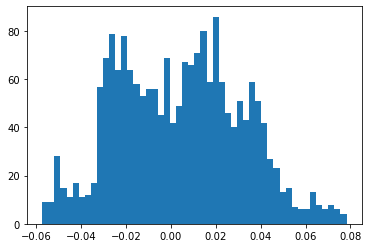

In [299]:
_=plt.hist(esps_psi4,bins=50)

In [309]:
shading = {"flat":False, # Flat or smooth shading of triangles
           "wireframe":False, "wire_width": 0.03, "wire_color": "black", # Wireframe rendering
           "width": 600, "height": 600, # Size of the viewer canvas
           "antialias": True, # Antialising, might not work on all GPUs
           "scale": 2.0, # Scaling of the model
           "side": "FrontSide", # FrontSide, BackSide or DoubleSide rendering of the triangles
           "colormap": "RdBu", "normalize": [None, None], # Colormap and normalization for colors
           "background": "#000000", # Background color of the canvas
          }

mp.plot(vert, faces, c=esps_psi4, shading=shading)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1405875…

# Render with fresnel

In [310]:
vert_winding = vert[faces].reshape(-1,3)

psi4_matrix = p4c.Matrix.from_array(vert_winding)

myepc = p4c.ESPPropCalc(wfn)

col_wind = np.array(myepc.compute_esp_over_grid_in_memory(psi4_matrix))

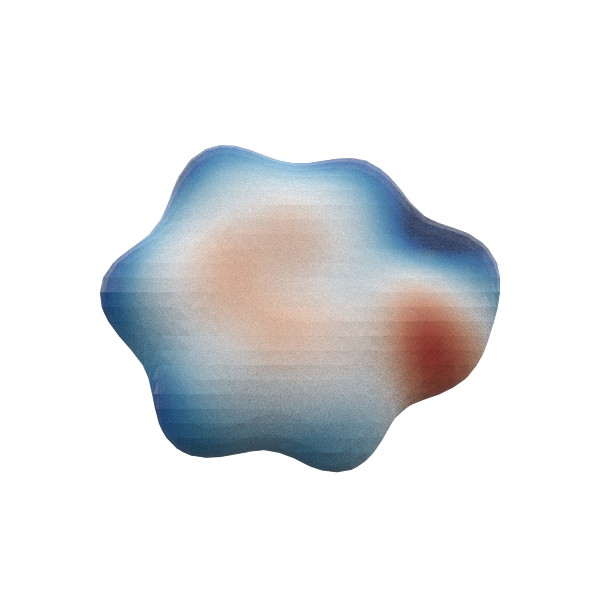

In [311]:
import fresnel
import matplotlib

#create a scene:
scene1 = fresnel.Scene()

#calculate colors with matplotlib:
mapper = matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin=-0.08, vmax=0.05, clip=True),
                                      cmap = matplotlib.cm.get_cmap(name='RdBu'))
colors = mapper.to_rgba(col_wind)


#create a geometry in that scene:
fres_geom = fresnel.geometry.Mesh(scene1, vertices=vert_winding)

fres_geom.color[:] = fresnel.color.linear(mapper.to_rgba(col_wind))
fres_geom.material.primitive_color_mix = 1.0

scene1.camera = fresnel.camera.Orthographic.fit(scene1, view='front', margin=0.5)


scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=300, h=600, w=600)

# Alternative approach (slower)

Interpolate the ESP values from the cube file


In [166]:
cube = parse_cube('ESP.cube')

In [176]:
from scipy import ndimage
values = cube['data'].copy()
points = myv
min_coords = np.array([cube['minx'], cube['miny'], cube['minz']])
grid_coords =(myv - min_coords) / 0.3

In [187]:
x = cube['minx']
y = cube['miny']
z = cube['minz']
pts = []
vals = []
for xn in range(cube['numx']):
    for yn in range(cube['numy']):
        for zn in range(cube['numz']):
            pt = np.array([x + xn*cube['incx'], y + yn*cube['incy'], z + zn*cube['incz']])
            pts.append(pt)
            vals.append(cube['data'][xn,yn,zn])
            
pts = np.array(pts)
vals= np.array(vals)

In [189]:
from scipy import interpolate
interp =interpolate.LinearNDInterpolator(pts, vals)

In [191]:
esp = interp(myv)